# Model Training: Defencemen - XGBRegressor

The task here will be to train a model to predict that value of NHL players who play the Defence position.

## Import our data

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [21]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv' 
data = pd.read_csv(filepath)

In [22]:
defence = data[data['POSITION'].isin(['d, l', 'd'])].copy()

# Select only players with 41 or more games played
defence_41GP = defence[(defence['GP'] >= 41)].copy()
test_train_data = defence_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

In [23]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features)
#     ]
# )

# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=500, max_depth=6, reg_lambda=0, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

# X = test_train_data[numerical_features]
# y = test_train_data['SALARY CAP PERCENTAGE']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

In [24]:
X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the estimator for RFE
estimator = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=500, max_depth=6, reg_lambda=0, eta=0.01)

# Define the pipeline
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features)])

# Use RFECV with cross validation for autmated feature selection
rfecv = RFECV(estimator=estimator, step=1, cv=KFold(2), scoring='neg_mean_squared_error', min_features_to_select=1)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selector', rfecv),
                           ('regressor', estimator)])

# Fitting the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Optimal number of features : {rfecv.n_features_}')


Mean Squared Error: 0.0005205706704350224
Optimal number of features : 41


In [25]:
# Print the training performance score
print(f'Training performance score: {rfecv.score(X_train, y_train)}')

# Print the testing performance score
print(f'Testing performance score: {rfecv.score(X_test, y_test)}')

Training performance score: -1.4972229112787754
Testing performance score: -1.5031255260662042


/Users/michaelkuby/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(
/Users/michaelkuby/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(


In [26]:
# Save the model to a file
import joblib

model_dir = 'Defence_Model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

joblib.dump(pipeline, f'{model_dir}/defence_salary_pipeline.pkl')
joblib.dump(numerical_features, f'{model_dir}/defence_salary_features.pkl')

['Defence_Model/defence_salary_features.pkl']

In [27]:
# # Perform Grid Search to find the optimal parameters
# param_grid = {
#     'regressor__n_estimators': [500, 1000, 1500],
#     'regressor__max_depth': [5, 10, 15],
#     'regressor__reg_lambda': [.1, 1, 10],
#     'regressor__eta': [0.01, 0.1, 0.3]
# }

# grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)
# print(grid_search.best_score_)
# print(grid_search.score(X_test, y_test))

# # {'regressor__eta': 0.01, 'regressor__max_depth': 5, 'regressor__n_estimators': 500, 'regressor__reg_lambda': 10}
# # 0.44245590658432327
# # 0.41148105470370877

In [28]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [29]:
# Create a feature column in Centers for the predicted salary
defence['PRED_SALARY_PERCENTAGE'] = pipeline.predict(defence)

# Create a column for the actual predicted salary
defence['PRED_AAV'] = defence['PRED_SALARY_PERCENTAGE'] * defence['SALARY CAP']
defence['PRED_AAV'] = defence['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
defence['DIFF'] = defence['PRED_AAV'] - defence['AAV']

# Convert to dollars
defence['PRED_AAV'] = convert_to_dollars(defence, 'PRED_AAV')
defence['AAV'] = convert_to_dollars(defence, 'AAV')
defence['DIFF'] = convert_to_dollars(defence, 'DIFF')

In [30]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = defence.sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(25)
display_features = ['PLAYER', 'SEASON']  + ['AAV', 'PRED_AAV', 'DIFF', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
414,zdeno chara,2007-08,"$7,500,000.00","$6,852,333.00","$-647,667.00",0.136229
10023,erik karlsson,2021-22,"$11,500,000.00","$10,866,064.00","$-633,936.00",0.133326
11627,erik karlsson,2023-24,"$11,500,000.00","$10,393,077.00","$-1,106,923.00",0.124468
4875,p.k. subban,2014-15,"$9,000,000.00","$8,299,885.00","$-700,115.00",0.120288
8466,erik karlsson,2019-20,"$11,500,000.00","$9,728,554.00","$-1,771,446.00",0.119369
1521,zdeno chara,2009-10,"$7,500,000.00","$6,773,988.00","$-726,012.00",0.119260
940,zdeno chara,2008-09,"$7,500,000.00","$6,731,249.00","$-768,751.00",0.118717
10834,drew doughty,2022-23,"$11,000,000.00","$9,734,069.00","$-1,265,931.00",0.117989
5685,p.k. subban,2015-16,"$9,000,000.00","$8,410,122.00","$-589,878.00",0.117789
11606,drew doughty,2023-24,"$11,000,000.00","$9,800,189.00","$-1,199,811.00",0.117368


In [31]:
# Display all seasons for Connor McDavid
cale_makar = defence[defence['PLAYER'] == 'cale makar']
cale_makar[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
8349,cale makar,2019-20,"$2,854,166.00","$1,810,740.00","$-1,043,426.00",0.022218
9096,cale makar,2020-21,"$2,854,166.00","$1,580,594.00","$-1,273,572.00",0.019394
9899,cale makar,2021-22,"$9,000,000.00","$5,913,159.00","$-3,086,841.00",0.072554
11527,cale makar,2023-24,"$9,000,000.00","$7,217,390.00","$-1,782,610.00",0.086436


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Defence')

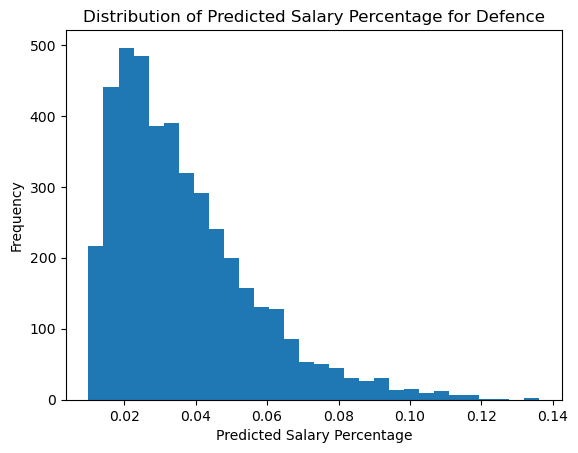

In [32]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(defence['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Defence')

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for Defence')

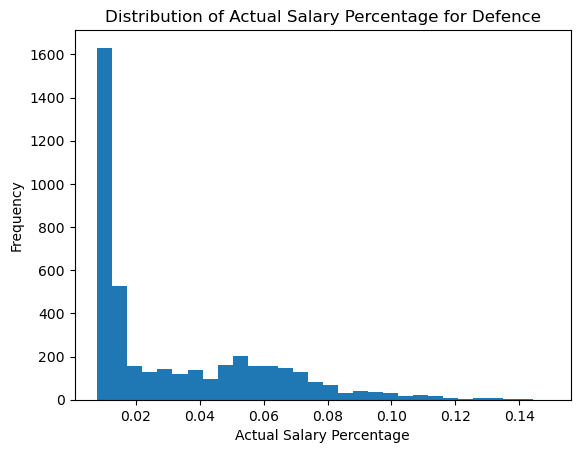

In [33]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(defence['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for Defence')

In [34]:
# Filter players with over 41 GP
filtered_data = defence[(defence['GP'] > 60) & (defence['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11695,ott,jake sanderson,2023-24,"$1,850,000.00","$4,783,605.00","$2,933,605.00",0.057289,2933605.0
11585,t.b,darren raddysh,2023-24,"$762,500.00","$2,723,100.00","$1,960,600.00",0.032612,1960600.0
11667,ari,j.j. moser,2023-24,"$925,000.00","$2,817,703.00","$1,892,703.00",0.033745,1892703.0
11706,dal,jani hakanpää,2023-24,"$1,500,000.00","$3,378,589.00","$1,878,589.00",0.040462,1878589.0
12074,dal,thomas harley,2023-24,"$1,288,333.00","$3,125,283.00","$1,836,950.00",0.037429,1836950.0
11521,min,brock faber,2023-24,"$1,008,333.00","$2,655,313.00","$1,646,980.00",0.031800,1646980.0
11789,n.j,kevin bahl,2023-24,"$1,050,000.00","$2,525,951.00","$1,475,951.00",0.030251,1475951.0
11534,phi,cam york,2023-24,"$1,600,000.00","$3,046,981.00","$1,446,981.00",0.036491,1446981.0
11649,fla,gustav forsling,2023-24,"$2,666,667.00","$4,042,479.00","$1,375,812.00",0.048413,1375812.0
11441,nyi,alexander romanov,2023-24,"$2,500,000.00","$3,869,109.00","$1,369,109.00",0.046337,1369109.0


In [35]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(30)

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11831,cgy,mackenzie weegar,2023-24,"$6,250,000.00","$5,606,764.00","$-643,236.00",0.067147,-643236.0
12015,nsh,ryan mcdonagh,2023-24,"$6,750,000.00","$6,093,190.00","$-656,810.00",0.072972,-656810.0
11476,det,ben chiarot,2023-24,"$4,750,000.00","$4,076,406.00","$-673,594.00",0.048819,-673594.0
11543,bos,charlie mcavoy,2023-24,"$9,500,000.00","$8,786,160.00","$-713,840.00",0.105223,-713840.0
12080,stl,torey krug,2023-24,"$6,500,000.00","$5,778,285.00","$-721,715.00",0.069201,-721715.0
11564,stl,colton parayko,2023-24,"$6,500,000.00","$5,742,801.00","$-757,199.00",0.068776,-757199.0
12065,tor,tj brodie,2023-24,"$5,000,000.00","$4,239,081.00","$-760,919.00",0.050767,-760919.0
11513,edm,brett kulak,2023-24,"$2,750,000.00","$1,879,787.00","$-870,213.00",0.022512,-870213.0
12010,pit,ryan graves,2023-24,"$4,500,000.00","$3,527,927.00","$-972,073.00",0.042251,-972073.0
11923,wsh,nick jensen,2023-24,"$4,050,000.00","$3,051,736.00","$-998,264.00",0.036548,-998264.0


In [36]:
# Show all players who have a positive differential
filtered_data[filtered_data['Differential'] > 0][['TEAM'] + display_features + ['Differential']].head(30)

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11695,ott,jake sanderson,2023-24,"$1,850,000.00","$4,783,605.00","$2,933,605.00",0.057289,2933605.0
11585,t.b,darren raddysh,2023-24,"$762,500.00","$2,723,100.00","$1,960,600.00",0.032612,1960600.0
11667,ari,j.j. moser,2023-24,"$925,000.00","$2,817,703.00","$1,892,703.00",0.033745,1892703.0
11706,dal,jani hakanpää,2023-24,"$1,500,000.00","$3,378,589.00","$1,878,589.00",0.040462,1878589.0
12074,dal,thomas harley,2023-24,"$1,288,333.00","$3,125,283.00","$1,836,950.00",0.037429,1836950.0
11521,min,brock faber,2023-24,"$1,008,333.00","$2,655,313.00","$1,646,980.00",0.031800,1646980.0
11789,n.j,kevin bahl,2023-24,"$1,050,000.00","$2,525,951.00","$1,475,951.00",0.030251,1475951.0
11534,phi,cam york,2023-24,"$1,600,000.00","$3,046,981.00","$1,446,981.00",0.036491,1446981.0
11649,fla,gustav forsling,2023-24,"$2,666,667.00","$4,042,479.00","$1,375,812.00",0.048413,1375812.0
11441,nyi,alexander romanov,2023-24,"$2,500,000.00","$3,869,109.00","$1,369,109.00",0.046337,1369109.0


In [37]:
filtered_data[filtered_data['PLAYER'] == 'quinn hughes'][['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11983,van,quinn hughes,2023-24,"$7,850,000.00","$7,525,088.00","$-324,912.00",0.090121,-324912.0


In [39]:
predictions = defence[['PLAYER', 'SEASON', 'PRED_AAV','PRED_SALARY_PERCENTAGE']]

# Save predictions to disk
save_dir = '../../Data/Warehouse/Predictions/' 
filename = 'defence_predictions.csv'

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the predictions to disk
predictions.to_csv(save_dir + filename, index=True)